# Test of the neural network for the San Pedro River Basin 

### This Notebook runs the neural network on some test cases and compares the predictions with MODFLOW calculations in the attached data 'Well_data_examps'

In [1]:
# Import
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import os
from time import time
import matplotlib.pyplot as plt
import tensorflow as tf
import joblib
import scipy.ndimage
import scipy.signal
import skfmm
import h5py
from urllib.request import urlretrieve as urlretrieve

### In Google Colab

In [2]:
!pip install scikit-fmm

### Here are some functions, that we use to create input data for the neural network. Loaded text files contain data on stream locations and hydraulic conductivities that are extracted from the MODFLOW model

In [3]:
#distance to stream 
def dist():
    if os.path.exists('str.txt'):
        data_str = np.loadtxt('str.txt')
        data_hk = np.loadtxt('hyd_kon')
    if not os.path.exists('str.txt'):
        url_str = 'https://github.com/MathiasBusk/HYDROsim-paper/raw/main/str.txt'
        Path_str = tf.keras.utils.get_file('str.txt', url_str)
        data_str = np.loadtxt(Path_str)
        url_hk = 'https://github.com/MathiasBusk/HYDROsim-paper/blob/main/hyd_kon?raw=true'
        Path_hk = tf.keras.utils.get_file('hyd_kon', url_hk)
        data_hk = np.loadtxt(Path_hk)

    row = (data_str[:,1])
    col = (data_str[:,2])

    row = row.astype(int)
    col = col.astype(int)

    data_hks = data_hk[::-1]
    hyk = np.flipud((data_hks))

    xmax = 80000
    ymax = 110000
    X, Y = np.meshgrid(np.linspace(0,xmax,320), np.linspace(ymax,0,440))
    phi =  -1* np.ones_like(X)
    phi[row,col] = 1

    d = skfmm.distance(phi,dx=250) 
    d = -d
    return d


In [4]:
#distance to well
def well_dist(row,col): 
    xmax = 80000
    ymax = 110000
    X, Y = np.meshgrid(np.linspace(0,xmax,320), np.linspace(ymax,0,440))
    phi =  -1* np.ones_like(X)
    phi[row,col] = 1

    d_well = skfmm.distance(phi,dx=250) 
    d_well = -d_well
    return d_well

In [5]:
#travel time from to well
def travel_time(row,col,h0):
    if os.path.exists('hyd_kon'):
        data_hk = np.loadtxt('hyd_kon')
    if not os.path.exists('hyd_kon'):
        url_hk = 'https://github.com/MathiasBusk/HYDROsim-paper/blob/main/hyd_kon?raw=true'
        Path_hk = tf.keras.utils.get_file('hyd_kon', url_hk)
        data_hk = np.loadtxt(Path_hk)

        
    result = np.where(h0 == -999)
    result = np.array(result)
    data_hks = data_hk[::-1]
    hyk = np.flipud((data_hks))
    hyk +=0.1

    hk_smooth = scipy.ndimage.filters.gaussian_filter(hyk,(6.5,6.5))
    hk_smooth[result[0,:],result[1,:]] = -2

    hyk = np.flipud((data_hks))

    xmax = 80000
    ymax = 110000
    X, Y = np.meshgrid(np.linspace(0,320,320), np.linspace(440,0,440))
    #X = X[::-1]
    #Y = Y[::-1]
    phi =  np.ones_like(hyk)*hyk
    phi[phi == 0] = 0
    phi[phi != 0] = -1
    phi[row,col] = 1

    speed=np.ones_like(phi)*hk_smooth
    t = skfmm.travel_time(phi, speed,dx=250)
    return t

In [6]:
#Generates pandas dataframe with input data
def data_gen(i,j,data0):
    if os.path.exists('hyd_kon'):
        data_hk = np.loadtxt('hyd_kon')
        d_boundary = np.load('d_boundary.npy')
        row_nr = np.load('row_nr.npy')
        col_nr = np.load('col_nr.npy')
        
    if not os.path.exists('hyd_kon'):      
        url_hk = 'https://github.com/MathiasBusk/HYDROsim-paper/blob/main/hyd_kon?raw=true'
        url_bound = 'https://github.com/MathiasBusk/HYDROsim-paper/blob/main/d_boundary.npy?raw=true'
        url_row = 'https://github.com/MathiasBusk/HYDROsim-paper/blob/main/row_nr.npy?raw=true'
        url_col = 'https://github.com/MathiasBusk/HYDROsim-paper/blob/main/col_nr.npy?raw=true'

        Path_hk = tf.keras.utils.get_file('hyd_kon', url_hk)
        Path_bound = tf.keras.utils.get_file('d_boundary.npy', url_bound)
        Path_row = tf.keras.utils.get_file('row_nr.npy', url_row)
        Path_col = tf.keras.utils.get_file('col_nr.npy', url_col)
    
        data_hk = np.loadtxt(Path_hk)
        d_boundary = np.load(Path_bound)
        row_nr = np.load(Path_row)
        col_nr = np.load(Path_col)
    
    #d_boundary = np.load('d_boundary.npy')
    #row_nr = np.load('row_nr.npy')
    #col_nr = np.load('col_nr.npy')
    #data_hk = np.loadtxt('hyd_kon')
    
    data_hks = data_hk[::-1]
    hyk = np.flipud((data_hks))
    t = travel_time(i,j,data0)
    d_well = well_dist(i,j)
    d = dist()
    
    #head_diff = np.reshape(head_differ,(320*440))
    dists = np.reshape(d,(320*440))
    dist_b = np.reshape(d_boundary,(320*440))
    time = np.reshape(t,(320*440))
    dist_well = np.reshape(d_well,(320*440))
    head0 = np.reshape(data0,(320*440))
    hykk = np.reshape(hyk,(320*440))
    hykk_l = np.reshape(np.log10(hyk),(320*440))
    row = np.reshape(row_nr,(320*440))
    col = np.reshape(col_nr,(320*440))
    

    data_set_t= pd.DataFrame(head0)
    
    data_set_t.columns = ["head"]

    #data_set_t['head']=head0   
    data_set_t['dist']=dists
    data_set_t['time']=time
    data_set_t['dist_well']=dist_well
    data_set_t['h_cond']=hykk
    data_set_t['h_cond_log']=hykk_l
    data_set_t['row']=row
    data_set_t['col']=col
    data_set_t['dist_boundary']=dist_b
    data_set_t = data_set_t[(data_set_t[['head']] != -999).all(axis=1)]
    data_set_t = data_set_t[(data_set_t[['time']] != 0).all(axis=1)]
    data_set_t = data_set_t[(data_set_t[['dist_boundary']] > 750).all(axis=1)]
  
    return data_set_t

In [7]:
def data_scatter(i,j,data0,head_differ):
    if os.path.exists('d_boundary.npy'):
        d_boundary = np.load('d_boundary.npy')
        
    if not os.path.exists('d_boundary.npy'):      
        url_bound = 'https://github.com/MathiasBusk/HYDROsim-paper/blob/main/d_boundary.npy?raw=true'
        Path_bound = tf.keras.utils.get_file('d_boundary.npy', url_bound)
        d_boundary = np.load(Path_bound)

    
    #d_boundary = np.load('d_boundary.npy')
    t = travel_time(i,j,data0)
    head_diff = np.reshape(head_differ,(320*440))
    dist_b = np.reshape(d_boundary,(320*440))
    time = np.reshape(t,(320*440))
    head0 = np.reshape(data0,(320*440))

    

    data_set_t= pd.DataFrame(head_diff)   
    data_set_t.columns = ["head_differ"]

    data_set_t['head']=head0   
    data_set_t['time']=time
    data_set_t['dist_boundary']=dist_b
    data_set_t = data_set_t[(data_set_t[['head']] != -999).all(axis=1)]
    data_set_t = data_set_t[(data_set_t[['time']] != 0).all(axis=1)]
    data_set_t = data_set_t[(data_set_t[['dist_boundary']] > 750).all(axis=1)]
    return data_set_t

### Load data on hydraulic head changes from well simulations in MODFLOW

In [8]:
Path =  os.path.join("Well_data_exampss")


if os.path.exists(Path):
    files = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(Path):
        for file in f:
            if '.npy' in file:
                files.append(os.path.join(r, file))

    row_len = 440
    col_len = 320
    data = np.empty((len(files),row_len,col_len))
    for i in range(len(files)):
        dats = np.load(files[i])
        data[i,:,:] = dats[3,:,:]
        
    data0 = np.load(os.path.join("Well_data_examps/no_pump",'head_no_pump.npy'))
            

if not os.path.exists(Path):
    url1 = 'https://github.com/MathiasBusk/HYDROsim-paper/blob/main/Well_data_examps/head_137.0_182.0_rate200.npy?raw=true'
    url2 = 'https://github.com/MathiasBusk/HYDROsim-paper/blob/main/Well_data_examps/head_157.0_222.0_rate200.npy?raw=true'
    url3 = 'https://github.com/MathiasBusk/HYDROsim-paper/blob/main/Well_data_examps/head_180.0_174.0_rate200.npy?raw=true'
    url4 = 'https://github.com/MathiasBusk/HYDROsim-paper/blob/main/Well_data_examps/head_212.0_197.0_rate200.npy?raw=true'
    url5 = 'https://github.com/MathiasBusk/HYDROsim-paper/blob/main/Well_data_examps/head_255.0_221.0_rate200.npy?raw=true'
    url = [url1, url2, url3, url4, url5]
    row_len = 440
    col_len = 320
    data = np.empty((len(url),row_len,col_len))
    
    for i in range(len(url)):
        print(url[i])
        Path = tf.keras.utils.get_file(url[i][73:101], url[i])
        dats = np.load(Path)
        data[i,:,:] = dats[3,:,:]
    url0 = 'https://github.com/MathiasBusk/HYDROsim-paper/blob/main/Well_data_examps/no_pump/head_no_pump.npy?raw=true'
    Path = tf.keras.utils.get_file('no_pump.npy', url0)
    data0 = np.load(Path)



https://github.com/MathiasBusk/HYDROsim-paper/blob/main/Well_data_examps/head_137.0_182.0_rate200.npy?raw=true
https://github.com/MathiasBusk/HYDROsim-paper/blob/main/Well_data_examps/head_157.0_222.0_rate200.npy?raw=true
https://github.com/MathiasBusk/HYDROsim-paper/blob/main/Well_data_examps/head_180.0_174.0_rate200.npy?raw=true
https://github.com/MathiasBusk/HYDROsim-paper/blob/main/Well_data_examps/head_212.0_197.0_rate200.npy?raw=true
https://github.com/MathiasBusk/HYDROsim-paper/blob/main/Well_data_examps/head_255.0_221.0_rate200.npy?raw=true


### The well locations [row, column] for each simulation are noted below

In [9]:
examps =np.array([[137,182], [157,222], [180, 174], [212,197], [255,221]])

### Load the pre-trained network

In [10]:
from keras.models import load_model
from keras.utils import plot_model
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import tensorflow_probability as tfp
tfd = tfp.distributions

if os.path.exists('my_model.h5'):
    model = tf.keras.models.load_model('my_model.h5',compile=False)
    sc=joblib.load('std_scaler.bin')

if not os.path.exists('my_model.h5'):
    url = 'https://github.com/MathiasBusk/HYDROsim-paper/blob/main/my_model.h5?raw=true'
    url_scaler = 'https://github.com/MathiasBusk/HYDROsim-paper/raw/main/std_scaler.bin'
    
    Path = tf.keras.utils.get_file('my_model.h5', url)
    Path_scaler = tf.keras.utils.get_file('std_scaler.bin', url_scaler)
    
    model = tf.keras.models.load_model(Path,compile=False)
    sc = joblib.load(Path_scaler)



model.summary()

Using TensorFlow backend.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputA (InputLayer)          [(None, 6)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 75)                525       
_________________________________________________________________
dense_3 (Dense)              (None, 75)                5700      
_________________________________________________________________
dense_4 (Dense)              (None, 75)                5700      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 152       
_________________________________________________________________
distribution_lambda (Distrib ((None, 1), (None, 1))    0         
Total params: 12,077
Trainable params: 12,077
Non-trainable params: 0
_______________________________________________________

### The 'data_select' variable determines what simulation scenario is run - check the 'examps' array for row and column number.

In [17]:
data_select = 0 #0,1,2,3 or 4
row = examps[data_select,0]
col = examps[data_select,1]


###  Input data for the network is generated. The input parameters are scaled with a standard scaler and the network is applied to predict hydraulic head changes from the given inputs. The outputs are mean hydraulic head change and standard deviaiton on that prediction.

In [18]:
data_sets = data_gen(row,col,data0[3,:,:])
data_scaled = sc.transform(data_sets.iloc[:,0:6]) 
t_1 = time()
y_hat = model(data_scaled)
mean = y_hat.mean()
stddev = y_hat.stddev()
t_2 = time()

print(f'Prediction time {np.round(t_2-t_1,3)} s')

Prediction time 0.026 s


C:\Users\DAHL\Anaconda3\envs\Deeplearning\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log10


### The predictions are compared to MODFLOW values in the following subplot

In [19]:
data_ML = np.empty((row_len,col_len))
data_ML.fill(np.nan)
data_set = np.array(data_sets.iloc[:,:])

rows = data_set[:,-3].astype(int)
cols = data_set[:,-2].astype(int)
data_ML[rows,cols]=mean[:,0] 


data_st = np.empty((row_len,col_len))
data_st.fill(np.nan)

data_st[rows,cols]=stddev[:,0] 

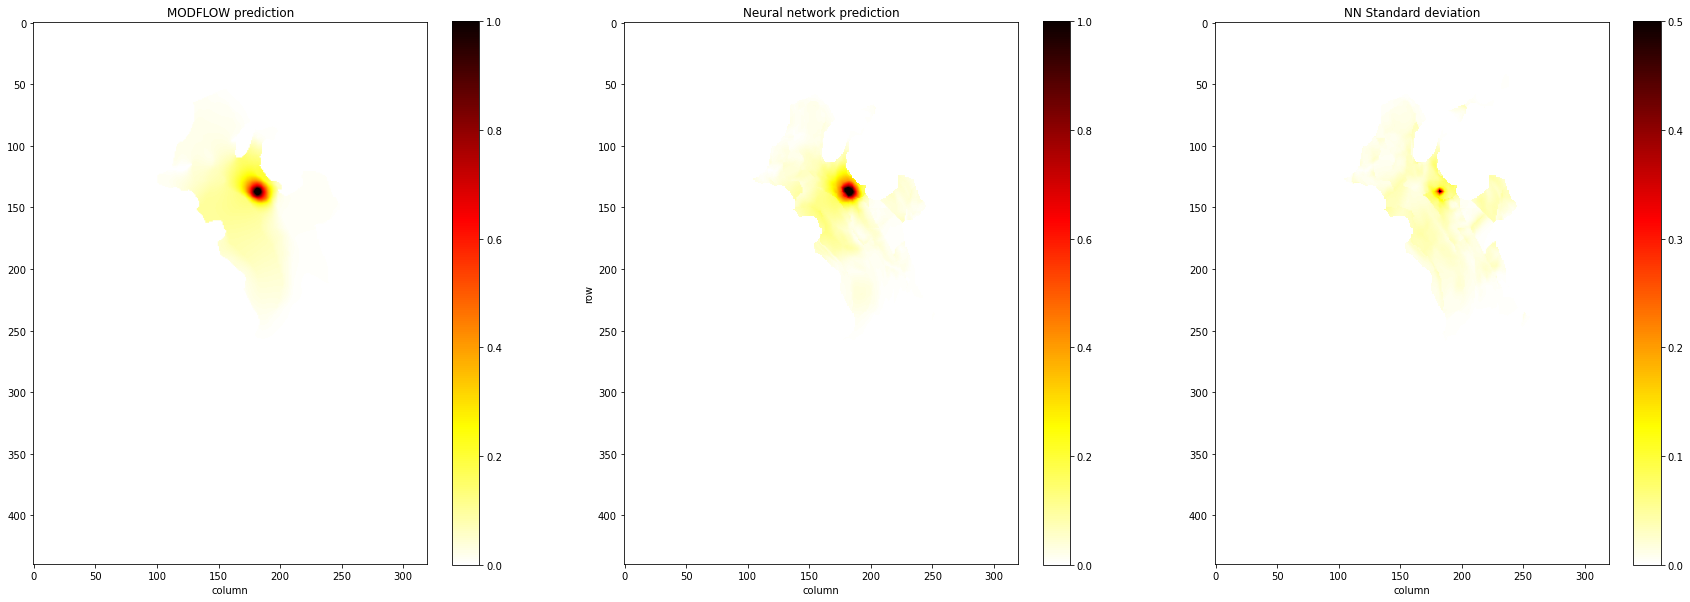

In [20]:
fig, (ax3, ax1, ax2) = plt.subplots(1,3)


fig.set_figheight(10)
fig.set_figwidth(30)

c1 = ax1.imshow(data_ML, vmin=0, vmax=1, cmap='hot_r')
ax1.set(xlabel='column', ylabel='row',title='Neural network prediction')
fig.colorbar(c1,ax = ax1)

c2 = ax2.imshow(data_st,cmap='hot_r',vmin=0,vmax=.5)
ax2.set(xlabel='column',title='NN Standard deviation')
fig.colorbar(c2,ax = ax2)

c3 = ax3.imshow(data0[3,:,:]-data[data_select,:,:],cmap='hot_r',vmin=0,vmax=1)
ax3.set(xlabel='column',title='MODFLOW prediction')
fig.colorbar(c3,ax = ax3)


### The following scatterplot compares the predictions on a 1-1 scale. x-axis shows MODFLOW head change values. y-axis shows predicted head change values from the neural network along with a 95 % confidence interval. 

In [21]:
y_testi = data_scatter(row,col,data0[3,:,:],(data0[3,:,:]-data[data_select,:,:]))
y_testi = y_testi.iloc[:,0]
err = 1.96*stddev

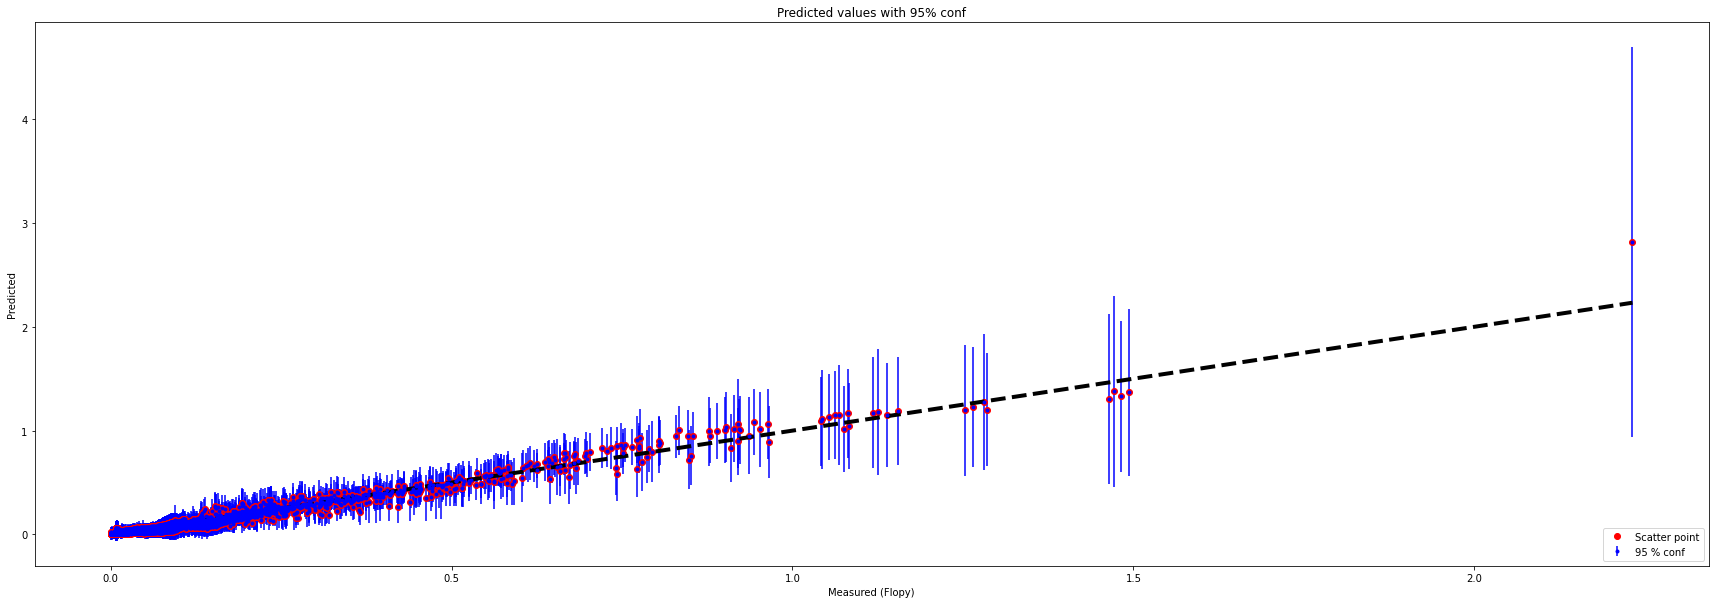

In [22]:
plt.figure(figsize=(30,10))
plt.errorbar(y_testi,mean,yerr=err[:,0],fmt='.', color='b', label='95 % conf')
plt.plot(y_testi,mean,'ro', label='Scatter point')
plt.plot([y_testi.min(), y_testi.max()], [y_testi.min(), y_testi.max()], 'k--', lw=4)
#plt.ylim([0,0.5])
#plt.xlim([0,0.5])
plt.ylabel('Predicted')
plt.xlabel('Measured (Flopy)')
plt.title('Predicted values with 95% conf')
plt.legend(loc='lower right')
plt.show()

### Test the network compared to MODFLOW in a different scenario by changing the 'data_select' value